In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Activation, Flatten, Dropout,BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.preprocessing.image import load_img, img_to_array

from sklearn import datasets
from sklearn.model_selection import train_test_split

import keras
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix
import seaborn as sns

import io
import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

# 1. 전이학습을 이용한 small cat dog 인식

### 1)압축파일 풀기
- cd 명령어로 폴더 이동
- unzip

In [ ]:
%cd /content/
!unzip smallcatdog.zip

In [ ]:
%cd /content/drive/MyDrive/data/smallcatdog
!unzip smallcatdog.zip
%cd /content/

In [ ]:
%cd /content/

/content
/content


### 2) ImageDataGenerator를 이용한 데이터 읽기

In [ ]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/smallcatdog/train',  
        target_size=(224, 224), 
        batch_size=batch_size,
        class_mode='binary') 

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/data/smallcatdog/test',  
        target_size=(224, 224), 
        batch_size=batch_size,
        class_mode='binary') 

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### 3) CNN을 이용한 네트워크 설계

In [ ]:
def dogcatcnn() :
  model = Sequential()
  model.add(Convolution2D(32, (3, 3), input_shape=(224, 224,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Convolution2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Convolution2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Convolution2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten()) 
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer = 'adam',  loss = 'sparse_categorical_crossentropy',metrics=['accuracy']) 

  return model

### 4) 학습

In [ ]:
with tf.device(device_name):
  dogcat_model =  dogcatcnn()
  history = dogcat_model.fit(train_generator, epochs=1)

125/125 [==============================] - 58s 208ms/step - loss: 0.6985 - accuracy: 0.4945


In [ ]:
history = dogcat_model.fit(train_generator, epochs=4)

Epoch 1/4
125/125 [==============================] - 27s 217ms/step - loss: 0.6931 - accuracy: 0.5055
Epoch 2/4
125/125 [==============================] - 26s 209ms/step - loss: 0.6888 - accuracy: 0.5410
Epoch 3/4
125/125 [==============================] - 26s 208ms/step - loss: 0.6940 - accuracy: 0.5060
Epoch 4/4
125/125 [==============================] - 27s 217ms/step - loss: 0.6935 - accuracy: 0.5220


In [ ]:
dogcat_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

### 5) 전이학습을 이용한 CNN 설계

- 사전에 잘 학습된 신경망 모델을 사용해서 새롭게 학습
- ImageNet으로 학습된 CNN 사용( 특징 추출)

In [ ]:
image_size = 224
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
vgg_conv.summary()

#vgg_conv.trainable = False

for layer in vgg_conv.layers[:]:
      print(layer.name, layer.trainable)
      layer.trainable = False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
def dogcat_transfer_cnn() :
  image_size = 224
  vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
  vgg_conv.trainable = False

  model = Sequential()
  model.add(vgg_conv)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer = 'adam',  loss = 'sparse_categorical_crossentropy',metrics=['accuracy']) 
  return model

dogcat_transfer_cnn_model = dogcat_transfer_cnn()
dogcat_transfer_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
with tf.device(device_name):
  dogcat_transfer_cnn_model = dogcat_transfer_cnn()
  dogcat_transfer_cnn_model.fit(train_generator, epochs=5)

Epoch 1/5
125/125 [==============================] - 33s 237ms/step - loss: 0.6324 - accuracy: 0.8130
Epoch 2/5
125/125 [==============================] - 29s 231ms/step - loss: 0.2991 - accuracy: 0.8835
Epoch 3/5
125/125 [==============================] - 30s 243ms/step - loss: 0.2015 - accuracy: 0.9160
Epoch 4/5
125/125 [==============================] - 30s 243ms/step - loss: 0.1574 - accuracy: 0.9355
Epoch 5/5
125/125 [==============================] - 28s 227ms/step - loss: 0.1299 - accuracy: 0.9510


In [ ]:
dogcat_transfer_cnn_model.evaluate(test_generator)

50/50 [==============================] - 4s 79ms/step - loss: 0.2689 - accuracy: 0.9100


[0.26891928911209106, 0.9100000262260437]

In [ ]:
image = load_img('cat.png', target_size=(224, 224))
x = img_to_array(image)
x = np.expand_dims(x, axis=0)

pred = dogcat_transfer_cnn_model.predict(x)
print(pred)

[[1. 0.]]


# 2. YOLO 객체 검출

### 1) 가중치 download

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

### 2) OpenCV 모델 로딩

In [ ]:
classes = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat',
           'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
           'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
           'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 
           'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
           'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
           'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 
           'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 
           'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
           'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']



modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

### 3) 객체 검출

In [ ]:
frame = cv2.imread("cars.jpg")
blob = cv2.dnn.blobFromImage(frame, 1/255, (416, 416), [0,0,0], True, crop=False)
net.setInput(blob)
outs = net.forward(['yolo_82', 'yolo_94', 'yolo_106'])

### 4) 결과행렬 분석

- outs[0] :  yolo_82 출력 행렬, 507x85
  - 507 = 13x13x3,  13=블럭수, 3=B값
  - 85 = 4 + 1 + 80, 4=위치, 1=확률, 80=클래스확률
- outs[1] :  yolo_94 출력 행렬
  - 2028 = 26x26x3,  26=블럭수, 3=B값
  - 85 = 4 + 1 + 80, 4=위치, 1=확률, 80=클래스확률
- outs[2] :  yolo_106 출력 행렬
  - 8112 = 52x52x3,  52=블럭수, 3=B값
  - 85 = 4 + 1 + 80, 4=위치, 1=확률, 80=클래스확률

- 최종 bounding box 갯수 = 507+ 2028 + 8112 = 10647


In [ ]:
print(outs[0].shape, outs[1].shape, outs[2].shape)

(507, 85) (2028, 85) (8112, 85)


In [ ]:
v = outs[1][232]
print(v.shape)
print(f"bounding box{v[0:4]}")
print(f"객체 확률{v[4]}")
print(f"80 클래스 확률{v[5:]}")

(85,)
bounding box[0.9857716  0.08763082 0.19384977 0.09296101]
객체 확률1.0935357508401466e-08
80 클래스 확률[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
height, width, _  = frame.shape

for l in range(0,3) :
  print(f'layer_{l+1}')
  for v in outs[l] :
    #if v[4] > 0.5 : 
    if np.max(v[5:]) > 0.3 :
      x,y,w,h = v[0:4]
      x = int(x * width)
      y = int(y * height)
      w = int(w * width)
      h = int(h * height)
      name = classes[np.argmax(v[5:])]
      prob = np.max(v[5:])
      label = f"{name} - {int(prob*100)}%"
      print(x, y, w, h, label )

layer_1
956 683 361 227 car - 43%
1022 967 398 221 car - 92%
1042 966 402 216 truck - 36%
layer_2
579 355 184 160 car - 58%
1007 378 230 164 car - 95%
703 435 253 152 car - 83%
753 489 284 186 car - 97%
1350 560 317 219 car - 99%
928 677 296 235 car - 99%
1023 966 342 217 car - 66%
layer_3
341 321 104 75 car - 75%
546 319 38 29 person - 36%
977 324 45 27 person - 52%
453 339 84 30 car - 46%
709 442 66 35 person - 31%
1308 504 58 37 person - 62%
1396 509 56 30 person - 35%
1102 931 77 49 person - 32%
970 937 118 63 person - 59%


### 5) bounding box 그리기

layer_1
layer_2
layer_3


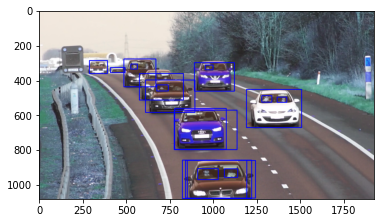

In [ ]:
output = frame.copy()

for l in range(0,3) :
  print(f'layer_{l+1}')
  for v in outs[l] :
    if np.max(v[5:]) > 0.3 :
      x,y,w,h = v[0:4]
      x = x - w/2
      y = y - h/2
      x = int(x * width)
      y = int(y * height)
      w = int(w * width)
      h = int(h * height)
      name = classes[np.argmax(v[5:])]
      prob = np.max(v[5:])
      label = f"{name} - {int(prob*100)}%"

      cv2.rectangle(output, (x,y), (x + w, y + h), (0,0,255), 3 )  

plt.imshow(output)
#cv2_imshow(output)

### 6) custom이미지를 이용한 YOLO  학습
- source code 컴파일
- yolo marker이용해 data 생성
- darknet 프로그램을 이용해 학습(GPU)
  - 전이학습을 위한 가중치 download(yolov4.conv.137)

In [ ]:
%cd /content
!git clone https://github.com/AlexeyAB/darknet.git

In [ ]:
%cd /content/darknet

/content/darknet


In [ ]:
# GPU
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make

In [ ]:
!wget github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
%cd /content/darknet
!chmod +x /content/darknet/darknet
!./darknet detector train custom/obj.data custom/yolov4.cfg yolov4.conv.137 -map -dont_show

/content/darknet
CUDA status Error: file: ./src/dark_cuda.c : () : line: 39 : build time: Aug 18 2021 - 05:39:50 

 CUDA Error: no CUDA-capable device is detected
Darknet error location: ./src/dark_cuda.c, check_error, line #70
CUDA Error: no CUDA-capable device is detected: Bad file descriptor


###### obj.data

- classes= 1
- train  = data/train.txt
- valid  = data/train.txt
- names = data/obj.names
- backup = backup/

###### yolov4.cfg 수정


- batch=16   GPU 크기에 따라 수정
- width=408    이미지 크기
- height=408   이미지 크기
- max_batches=3000  클래스수 * 2000
- steps=1400,1800    max_batches*0.8,  max_batches*0.9



- [yolo]
  - classes=1
- [yolo]위에 있는 [convolutional]
  - filters = 18 ( 클래스수+4+1)*3
- [yolo], [convolutional] 3개에 대해서  수정
  

In [ ]:
# OpenCV 최신버전 upgrade
cv2.__version__

'4.1.2'

In [ ]:
#!pip uninstall opencv-python
!pip install opencv-python

     |████████████████████████████████| 49.9 MB 16 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
